In [121]:
#instalação de pacotes
#!pip3 install pyramid-arima
!pip install pmdarima
!pip install mysql-connector-python
!pip install keras
!pip install tensorflow

In [122]:
#from statsmodels.tsa.stattools import adfuller
#from numpy import log
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Importa dados

In [123]:

import numpy as np
import pandas as pd
import mysql.connector

#Conecta com banco MySQL
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='projeto',
                                         user='root',
                                         password='12345678')

    produto_proc = "12886"
    
    sql_select_Query = " select ds_data_sem_hora \
                        ,isbn_produto \
                        ,qtd_venda  \
                        from fato_venda as ft \
                        , dim_tempo as tp \
                        , dim_produto as pd \
                        where tp.sk_tempo = ft.sk_tempo \
                        and pd.sk_produto = ft.sk_protudo \
                        and pd.sk_produto = " + produto_proc 
    
    cursor = connection.cursor()
    cursor.execute(sql_select_Query)
    
    #carrega dados
    records = cursor.fetchall()

    data_sql = pd.DataFrame(records)

except mysql.connector.Error as e:
    print("Error reading data from MySQL table", e)
finally:
    if connection.is_connected():
        connection.close()
        cursor.close()
        print("MySQL connection is closed")
        
data_sql.info()

MySQL connection is closed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2559 non-null   object
 1   1       2559 non-null   object
 2   2       2559 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 60.1+ KB


In [124]:
sql_select_Query

' select ds_data_sem_hora                         ,isbn_produto                         ,qtd_venda                          from fato_venda as ft                         , dim_tempo as tp                         , dim_produto as pd                         where tp.sk_tempo = ft.sk_tempo                         and pd.sk_produto = ft.sk_protudo                         and pd.sk_produto = 12886'

In [125]:
#ajusta dados para a predição
df1 = data_sql

#adiciona nome nas colunas
df1 = df1.rename(columns={0: "date",1:"isbn", 2: "value"})

#transforma para datetime
df1["date"] = pd.to_datetime(df1["date"])

#ordena
df1 = df1.sort_values('date')

#soma quantidade em datas iguais
df1 = df1.groupby('date')['value'].sum().reset_index()

#transforma a data em indice
df1 = df1.set_index('date')

#agrupa na soma do mês
df1 = df1['value'].resample('MS').sum()

Prepara dados

In [126]:
#Separa dados
train = df1.loc[:'2018-12-31']
test = df1.loc['2019-01-01':]

# Analisa os dados

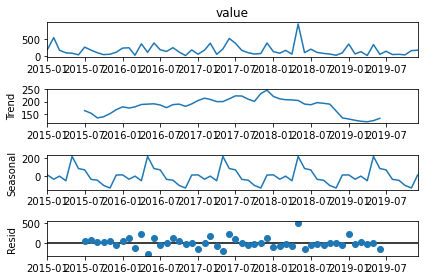

In [127]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt

a = seasonal_decompose(df1, model = "add")
a.plot();

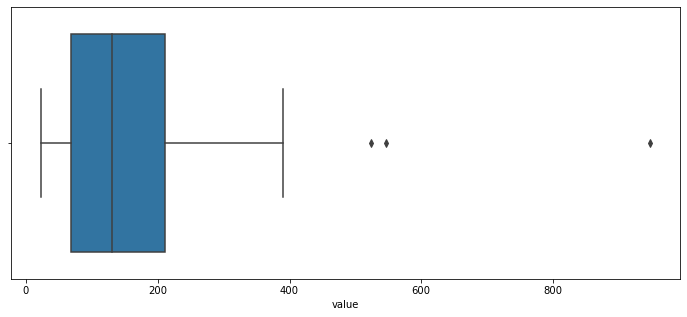

In [128]:
#Boxplot
import seaborn

fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(df1, ax=ax)

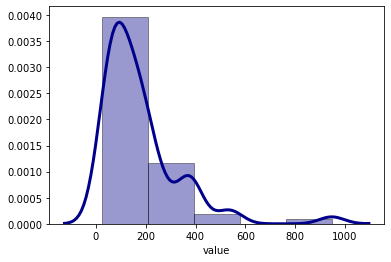

In [129]:
#Histograma
seaborn.distplot(df1, hist=True, kde=True, 
             bins=5, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3});

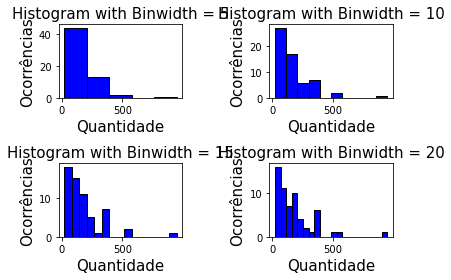

In [130]:
for i, binwidth in enumerate([5, 10, 15, 20]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(df1, bins = binwidth, color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 15)
    ax.set_xlabel('Quantidade', size = 15)
    ax.set_ylabel('Ocorrências', size= 15)

plt.tight_layout()
plt.show()

# Modelos

Modelo Auto ARIMA

In [131]:
import pmdarima as pm

#Fit modelo auto-arima
fitSArima = pm.auto_arima(df1, start_p=1, start_q=1,
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

#test='adf',

#fitSArima = pm.auto_arima(df1, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4) 

fitSArima.fit(train)

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [132]:
#Teste 1
pm.auto_arima(df1, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
              d=None, D=1, trace=False,error_action='ignore',suppress_warnings=True,stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   60
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -319.479
Date:                    Tue, 06 Apr 2021   AIC                            642.959
Time:                            21:04:58   BIC                            646.701
Sample:                                 0   HQIC                           644.373
                                     - 60                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6028      0.222     -2.717      0.007      -1.038      -0.168
sigma2      3.187e+04   3435.789      9.275      0.000    2.51e+04    3.86e+04
===================================================================================
Ljung-Box (Q):                       30.83   Jarque-Bera (JB):                90.81
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             1.87
Prob(H) (two-sided):                  0.18   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
#Teste 2
#pm.auto_arima(df1, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

In [134]:
#Forecast auto-arima
n_periods = 12
predSArima, confint = fitSArima.predict(n_periods=n_periods, return_conf_int=True)

#Cria dataseries
predSArima = pd.DataFrame(predSArima,index = test.index,columns=['SARIMA'])

Modelo Prophet

In [135]:
#Dados Prophet
df2 = data_sql

#adiciona nome nas colunas
df2 = df2.rename(columns={0: "ds",1:"isbn", 2: "y"})

#transforma para datetime
df2["ds"] = pd.to_datetime(df2["ds"])

df2['ds'] = df2['ds'].values.astype('datetime64[M]')

df2 = df2.groupby(['ds']).sum()

df2 = df2.reset_index()

In [136]:
from fbprophet import Prophet

#Fit modelo Prophet
fitProphet = Prophet()

fitProphet.fit(df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [137]:
#Forecast Prophet
future = fitProphet.make_future_dataframe(periods=12, freq='MS')

predProphet = fitProphet.predict(future)

predProphet1 = predProphet[['ds','yhat']]

predProphet1 = predProphet1.set_index('ds')
predProphet1 = predProphet1.rename(columns={"yhat": "PROPHET"})

predProphet1 = predProphet1['2019':'2019']

Modelo LSTM

In [138]:
#Dados LSTM

#importa dados
df3 = data_sql

#adiciona nome nas colunas
df3 = df3.rename(columns={0: "ds",1:"isbn", 2: "Venda"})

#transforma para datetime
df3["Mes"] = pd.to_datetime(df3["ds"])

df3['Mes'] = df3['Mes'].values.astype('datetime64[M]')

df3.drop(['ds','isbn'], axis=1, inplace=True)

df3 = df3.groupby(['Mes']).sum()

df3 = df3.reset_index()

df3 = df3.set_index("Mes")

df3.index.freq = 'MS'

train_data = df3[:len(df3)-12]
test_data = df3[len(df3)-12:]

In [139]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [140]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [141]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [142]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [143]:
nepochs=50
lstm_model.fit_generator(generator,epochs=nepochs)

Epoch 1/50


/home/rafael/Apps/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


36/36 [==============================] - 2s 14ms/step - loss: 0.0640
Epoch 2/50
36/36 [==============================] - 1s 17ms/step - loss: 0.0224
Epoch 3/50
36/36 [==============================] - 1s 18ms/step - loss: 0.0544
Epoch 4/50
36/36 [==============================] - 0s 11ms/step - loss: 0.0529
Epoch 5/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0554
Epoch 6/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0278
Epoch 7/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0443
Epoch 8/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0647
Epoch 9/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0352
Epoch 10/50
36/36 [==============================] - 1s 35ms/step - loss: 0.0312
Epoch 11/50
36/36 [==============================] - 1s 30ms/step - loss: 0.0228
Epoch 12/50
36/36 [==============================] - 1s 35ms/step - loss: 0.0211
Epoch 13/50
36/36 [=============================

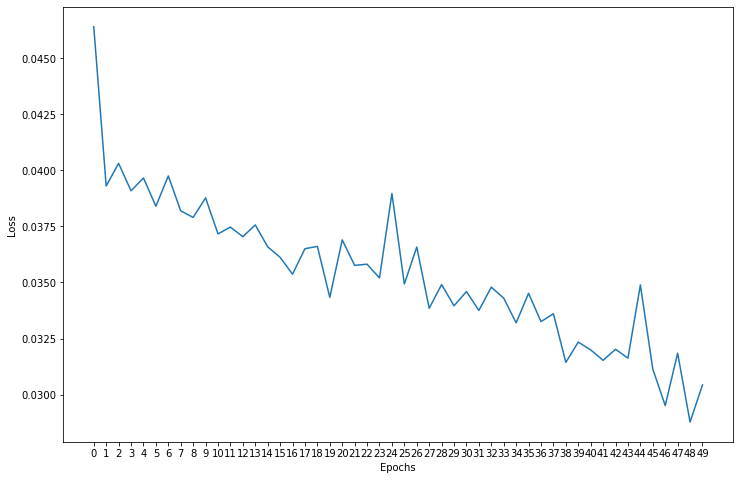

In [144]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,8))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,nepochs,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [145]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [146]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [147]:
test_data['LSTM'] = lstm_predictions

<ipython-input-147-1b3517f27687>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['LSTM'] = lstm_predictions


# Avaliação do Forecast

In [148]:
#Concatena predições
forecast = pd.concat([test,predSArima,predProphet1],axis=1)
forecast['LSTM'] = lstm_predictions

In [149]:
forecast

,value,SARIMA,PROPHET,LSTM
2019-01-01,361,131.612536,204.770039,118.139850
2019-02-01,70,147.870048,225.999004,137.092029
2019-03-01,136,211.375899,174.474940,211.223845
2019-04-01,25,93.706152,43.354319,299.503674
2019-05-01,344,662.000680,437.404970,380.123220
2019-06-01,59,228.431408,104.430145,215.637806
2019-07-01,150,251.412541,277.182969,219.357110
2019-08-01,53,134.184833,161.442753,201.648642
2019-09-01,60,106.688725,94.353877,197.249688
2019-10-01,43,72.195780,51.502058,195.959536


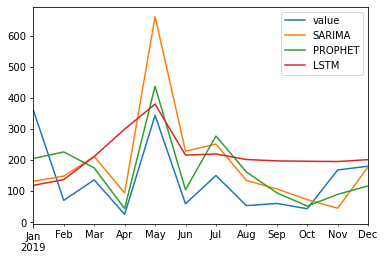

In [150]:
forecast.plot()

In [151]:
forecast['Ac_venda'] = test.cumsum()
forecast['Ac_SArima'] = forecast['SARIMA'].cumsum()
forecast['Ac_PROPHET'] = forecast['PROPHET'].cumsum()
forecast['Ac_LSTM'] = forecast['LSTM'].cumsum()

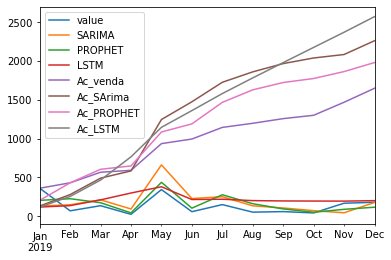

In [152]:
forecast.plot()

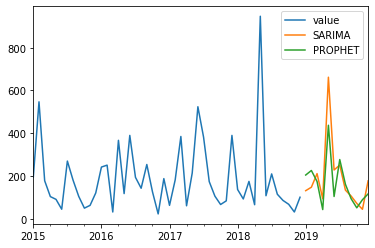

In [153]:
#Visão geral
pd.concat([train,predSArima,predProphet1],axis=1).plot()

Exporta Dados

In [154]:
#forecast.to_excel ('forecast.xlsx', index = True, header=True, sheet_name = 'Dados')

In [155]:
df_export = forecast.copy()
df_export["sk_tempo"] = df_export.index.strftime('%Y%m%d').astype(int)
df_export["sk_protudo"] = int(produto_proc)

df_export.drop(['value','Ac_venda'], axis=1, inplace=True)
df_export = df_export.rename(columns={"PROPHET":"qtd_prophet","Ac_PROPHET":"acm_prophet"})
df_export = df_export.rename(columns={"LSTM":"qtd_lstm","Ac_LSTM":"acm_lstm"})
df_export = df_export.rename(columns={"SARIMA":"qtd_sarima","Ac_SArima":"acm_sarima"})

df_export.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2019-01-01 to 2019-12-01
Freq: MS
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   qtd_sarima   12 non-null     float64
 1   qtd_prophet  12 non-null     float64
 2   qtd_lstm     12 non-null     float64
 3   acm_sarima   12 non-null     float64
 4   acm_prophet  12 non-null     float64
 5   acm_lstm     12 non-null     float64
 6   sk_tempo     12 non-null     int64  
 7   sk_protudo   12 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 864.0 bytes


In [156]:
#Grava dados no MySQL
try:
    # Connect to the database
    connection = mysql.connector.connect(host='localhost',
                                         database='projeto',
                                         user='root',
                                         password='12345678')

    cursor = connection.cursor()

    # Create a new record
    query = " DELETE FROM projeto.fato_predicao WHERE sk_protudo = " + produto_proc

    cursor.execute(query)

    # connection is not autocommit by default. So we must commit to save our changes.
    connection.commit()

    # Create a new record
    #query = """INSERT INTO projeto.fato_predicao (sk_tempo, sk_protudo, qtd_predicao, qtd_acumula) VALUES(%s, %s, %s, %s) ON DUPLICATE KEY UPDATE qtd_predicao=%s, qtd_acumula=%s"""
    #cursor.execute(query, (df_export.sk_tempo[i], df_export.sk_protudo[i], df_export.PROPHET[i], df_export.Ac_PROPHET[i], df_export.PROPHET[i], df_export.Ac_PROPHET[i]))

    query = """INSERT INTO projeto.fato_predicao (sk_tempo, sk_protudo, no_modelo, qtd_predicao, qtd_acumula) VALUES(%s, %s, %s, %s, %s) ON DUPLICATE KEY UPDATE qtd_predicao=%s, qtd_acumula=%s"""
    
    for index, row in df_export.iterrows():
        #Grava dados PROPHET
        cModelo = 'Prophet'
        nQtdInsert = row['qtd_prophet'].item() 
        nAcmInsert = row['acm_prophet'].item()
        
        cursor.execute(query, (row['sk_tempo'].item(), row['sk_protudo'].item(), cModelo, nQtdInsert, nAcmInsert, nQtdInsert, nAcmInsert))       

        #Grava dados SArima        
        cModelo = 'SArima'
        nQtdInsert = row['qtd_sarima'].item() 
        nAcmInsert = row['acm_sarima'].item()
        
        cursor.execute(query, (row['sk_tempo'].item(), row['sk_protudo'].item(), cModelo, nQtdInsert, nAcmInsert, nQtdInsert, nAcmInsert))       

        #Grava dados LSTM        
        cModelo = 'LSTM'
        nQtdInsert = row['qtd_lstm'].item() 
        nAcmInsert = row['acm_lstm'].item()
        
        cursor.execute(query, (row['sk_tempo'].item(), row['sk_protudo'].item(), cModelo, nQtdInsert, nAcmInsert, nQtdInsert, nAcmInsert))       

    # connection is not autocommit by default. So we must commit to save our changes.
    connection.commit()

    # Execute query
    sql = "SELECT * FROM projeto.fato_predicao"
    
    cursor.execute(sql)
    
    # Fetch all the records
    result = cursor.fetchall()
    
    for i in result:
        print(i)

finally:
    # close the database connection using close() method.
    connection.close()

(20190101, 5795, 'LSTM', Decimal('395.27'), Decimal('395.27'))
(20190101, 5795, 'Prophet', Decimal('285.93'), Decimal('285.93'))
(20190101, 5795, 'SArima', Decimal('84.35'), Decimal('84.35'))
(20190101, 12886, 'LSTM', Decimal('118.14'), Decimal('118.14'))
(20190101, 12886, 'Prophet', Decimal('204.77'), Decimal('204.77'))
(20190101, 12886, 'SArima', Decimal('131.61'), Decimal('131.61'))
(20190101, 13005, 'LSTM', Decimal('878.68'), Decimal('878.68'))
(20190101, 13005, 'Prophet', Decimal('3227.27'), Decimal('3227.27'))
(20190101, 13005, 'SArima', Decimal('398.00'), Decimal('398.00'))
(20190201, 5795, 'LSTM', Decimal('477.52'), Decimal('872.79'))
(20190201, 5795, 'Prophet', Decimal('359.18'), Decimal('645.11'))
(20190201, 5795, 'SArima', Decimal('343.33'), Decimal('427.68'))
(20190201, 12886, 'LSTM', Decimal('137.09'), Decimal('255.23'))
(20190201, 12886, 'Prophet', Decimal('226.00'), Decimal('430.77'))
(20190201, 12886, 'SArima', Decimal('147.87'), Decimal('279.48'))
(20190201, 13005, 'LS